In [1]:
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, BatchNormalization,Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [2]:
train = '../input/planets-dataset/planet/planet/train-jpg'
test = '../input/planets-dataset/planet/planet/test-jpg'
add_test = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'
train_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
sample_sub = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

In [3]:
train_df['image_name'] = train_df['image_name'].apply(lambda x: x+'.jpg')
sample_sub['image_name'] = sample_sub['image_name'].apply(lambda x: x+'.jpg')

In [4]:
train_df['tags'] = train_df['tags'].apply(lambda x:x.split(' '))

In [5]:
train_df.head()

,image_name,tags
0,train_0.jpg,"[haze, primary]"
1,train_1.jpg,"[agriculture, clear, primary, water]"
2,train_2.jpg,"[clear, primary]"
3,train_3.jpg,"[clear, primary]"
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]"


In [6]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [7]:
train_generator = datagen.flow_from_dataframe(
    subset='training',
    dataframe=train_df,
    directory=train,
    x_col='image_name',
    y_col='tags',
    batch_size=64,
    seed=42,
    target_size=(128,128)   
)
validation_generator = datagen.flow_from_dataframe(
    subset='validation',
    dataframe=train_df,
    directory=train,
    x_col="image_name",
    y_col="tags",
    batch_size=64,
    seed=42,
    target_size=(128,128)  
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_sub[:40669],
    directory=test,
    x_col='image_name',
    seed=42,
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(128,128)  
)
add_test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_sub[40669:],
    directory=add_test,
    x_col='image_name',
    seed=42,
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(128,128)
)

Found 30360 validated image filenames belonging to 17 classes.
Found 10119 validated image filenames belonging to 17 classes.
Found 40669 validated image filenames.
Found 20522 validated image filenames.


In [9]:
vgg_model = VGG16(input_shape=(128,128,3),
               weights='imagenet',
               include_top=False)


model = Sequential([
    BatchNormalization(input_shape=(128,128,3)),
    vgg_model,
    Flatten(),
    Dropout(0.5),
    Dense(17, activation='sigmoid')
])

58892288/58889256 [==============================] - 1s 0us/step


In [10]:
early_stop = EarlyStopping(patience=4,monitor='val_loss')
modelcheckpoints = ModelCheckpoint(filepath='trainmodel.hdf5',save_best_only=True,save_weights_only=True)

In [11]:
model.compile(loss='binary_crossentropy',optimizer=SGD(learning_rate=0.01),metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_ADD_TEST = add_test_generator.n//add_test_generator.batch_size

In [14]:
model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=validation_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=20,
           callbacks=[early_stop,modelcheckpoints]
)

Epoch 1/20
474/474 [==============================] - 187s 394ms/step - loss: 0.1820 - accuracy: 0.0835 - val_loss: 0.1421 - val_accuracy: 0.0815
Epoch 2/20
474/474 [==============================] - 130s 275ms/step - loss: 0.1368 - accuracy: 0.1226 - val_loss: 0.1200 - val_accuracy: 0.1036
Epoch 3/20
474/474 [==============================] - 131s 276ms/step - loss: 0.1246 - accuracy: 0.1348 - val_loss: 0.1137 - val_accuracy: 0.1046
Epoch 4/20
474/474 [==============================] - 131s 276ms/step - loss: 0.1185 - accuracy: 0.1406 - val_loss: 0.1108 - val_accuracy: 0.1245
Epoch 5/20
474/474 [==============================] - 202s 427ms/step - loss: 0.1133 - accuracy: 0.1427 - val_loss: 0.1052 - val_accuracy: 0.1164
Epoch 6/20
474/474 [==============================] - 131s 276ms/step - loss: 0.1101 - accuracy: 0.1424 - val_loss: 0.1055 - val_accuracy: 0.1002
Epoch 7/20
474/474 [==============================] - 133s 280ms/step - loss: 0.1071 - accuracy: 0.1451 - val_loss: 0.1031 -

In [15]:
model.save('trialmodel.h5')

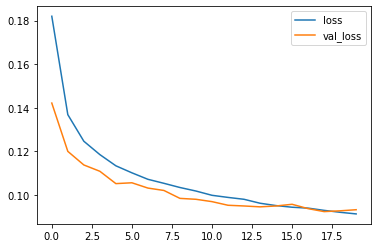

In [16]:
metrics = pd.DataFrame(model.history.history)
metrics[['loss','val_loss']].plot()

In [17]:
test_generator.reset()
result = model.predict_generator(test_generator,
                                steps=STEP_SIZE_TEST)

In [18]:
result[0]

array([2.06008740e-03, 2.12850602e-04, 2.26375239e-04, 1.98490135e-02,
       6.68159337e-04, 9.98065770e-01, 1.25519786e-04, 1.20681856e-04,
       1.27616152e-03, 4.53011453e-04, 9.31585324e-04, 8.51093442e-04,
       9.99913335e-01, 2.31854082e-03, 3.27043235e-03, 3.58212710e-04,
       2.24831467e-03], dtype=float32)

In [19]:
values = result>0.2
values = values.astype(int)
values[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [20]:
inv_map = {j:i for i,j in train_generator.class_indices.items()}

In [21]:
tags = []
for a in range(len(values)):
  column = []
  for i in range(len(values[a])):
    if values[a][i] == 1:
      column.append(inv_map[i])
  tags.append(' '.join(column))

In [22]:
sample_sub[:40669]['tags'] = tags

In [23]:
add_test_generator.reset()
add_result = model.predict_generator(add_test_generator,
                                steps=STEP_SIZE_ADD_TEST)

In [24]:
values = add_result>0.2
values = values.astype(int)
values[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [25]:
tags = []
for a in range(len(values)):
  column = []
  for i in range(len(values[a])):
    if values[a][i] == 1:
      column.append(inv_map[i])
  tags.append(' '.join(column))

In [26]:
len(tags)

20522

In [27]:
sample_sub[40669:]['tags'] = tags

In [28]:
sample_sub['image_name'] = sample_sub['image_name'].apply(lambda x:x[:-4])

In [29]:
sample_sub.to_csv('sixthsubmission.csv',index=False)